I mainly focused on three aspects of the data.

The first aspect is the relationship between features in the images of plankton. Some features are similar, allowing me to group them. Grouping features based on their covariances can help build a more efficient model. It provides justification for removing redundant features or applying Principal Component Analysis (PCA). Alternatively, I can derive new composite features. For example, while not finalized yet, I might combine circularity and convexity.

Additionally, if we use linear models such as logistic regression or Support Vector Machines (SVM) in further studies, multicollinearity due to highly correlated features could hinder interpretation, making it difficult to determine which features are critical for classification. Similarly, in neural networks like Convolutional Neural Networks (CNNs), redundant information can lead to weight redundancy, as redundant features learn the same underlying pattern, causing inefficient learning. Moreover, redundant features can make the model overly complex, leading to overfitting.

The second aspect is the issue of unbalanced labels. Since the data documentation states that the dataset is unbalanced and we have specific classes to focus on, I investigated how severe the imbalance is.

The third aspect involves variations and unusual values.

Before conducting exploratory data analysis (EDA), I used data from SIMC_OverlapTiffsWithPP. Additionally, to improve understanding, I merged all the data into one dataset before proceeding with the EDA. Notably, 9 out of 252 files contained three extra columns: {'Biovolume..P..Spheroid.', 'Biovolume..Sphere.', 'Biovolume..Cylinder.'}. Since they were not present in most files, I removed them.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

Before computing the covariance, I grouped features into three categories based on my knowledge:

Shape and Size Features: "Area..ABD.", "Area..Filled.", "Width", "Length", "Volume..ABD.", "Volume..ESD.", "Sphere.Volume", "Diameter..ABD.", "Diameter..ESD.", "Feret.Angle.Max", "Feret.Angle.Min"
Structural and Shape Features: "Symmetry", "Circularity", "Convexity", "Aspect.Ratio", "Compactness", "Elongation", "Fiber.Curl", "Fiber.Straightness", "Roughness"
Optical Features: "Transparency", "Sum.Intensity", "Intensity", "Sigma.Intensity", "Edge.Gradient"

The definitions of these columns can be found in GlossaryParticleProperties.pdf.

In [2]:
merged_df = pd.read_csv(r'C:\Users\sprin\Downloads\SIMC_OverlapTiffsWithPP\SIMC_OverlapTiffsWithPP\SIMC.Overlap.csv\merged_data.csv')

dimension_and_size_cols = [
    "Area..ABD.", "Area..Filled.", "Width", "Length", "Volume..ABD.", "Volume..ESD.", "Sphere.Volume", "Diameter..ABD.", "Diameter..ESD.", "Feret.Angle.Max", "Feret.Angle.Min"
]

structural_and_shape_cols = [
    "Symmetry", "Circularity", "Convexity", "Aspect.Ratio", "Compactness", "Elongation", "Fiber.Curl", "Fiber.Straightness", "Roughness"
]

optical_cols = [
    "Transparency", "Sum.Intensity", "Intensity", "Sigma.Intensity", "Edge.Gradient"
]

Next, I created a heatmap based on the covariance of each feature. Before drawing the heatmap, I standardized the data since the range of values varied significantly, and features had different scales.

As observed in the heatmap, my initial intuition regarding feature grouping was mostly correct. Three main clusters of highly correlated features (indicated in red) are visible. This is expected, as larger plankton areas correspond to larger width, length, and volume. Similarly, the structural and shape group exhibits strong internal relationships; for example, symmetry is inherently related to circularity.

Interestingly, the shape and size group has a weak relationship with the structural group. This is reasonable since the shape and size of plankton are largely independent of their structural properties. Another intriguing finding is the relationship between dimension and size features with optical features. One possible explanation is that larger plankton block more light, appearing darker, leading to correlations between width, length, diameter, transparency, and sum intensity. Additionally, the formula for transparency (Transparency = 1 - (ABD Diameter / ESD Diameter)) further explains why dimension and size features are correlated with optical properties.

Based on this analysis, dimensionality reduction can be considered using feature groups. To evaluate potential dimensionality reduction, I examined a heatmap of PCA loadings. The results indicate that dimension and size features dominate PC1 along with Sum.Intensity, suggesting redundancy. Therefore, it may be beneficial to merge them into a single feature.

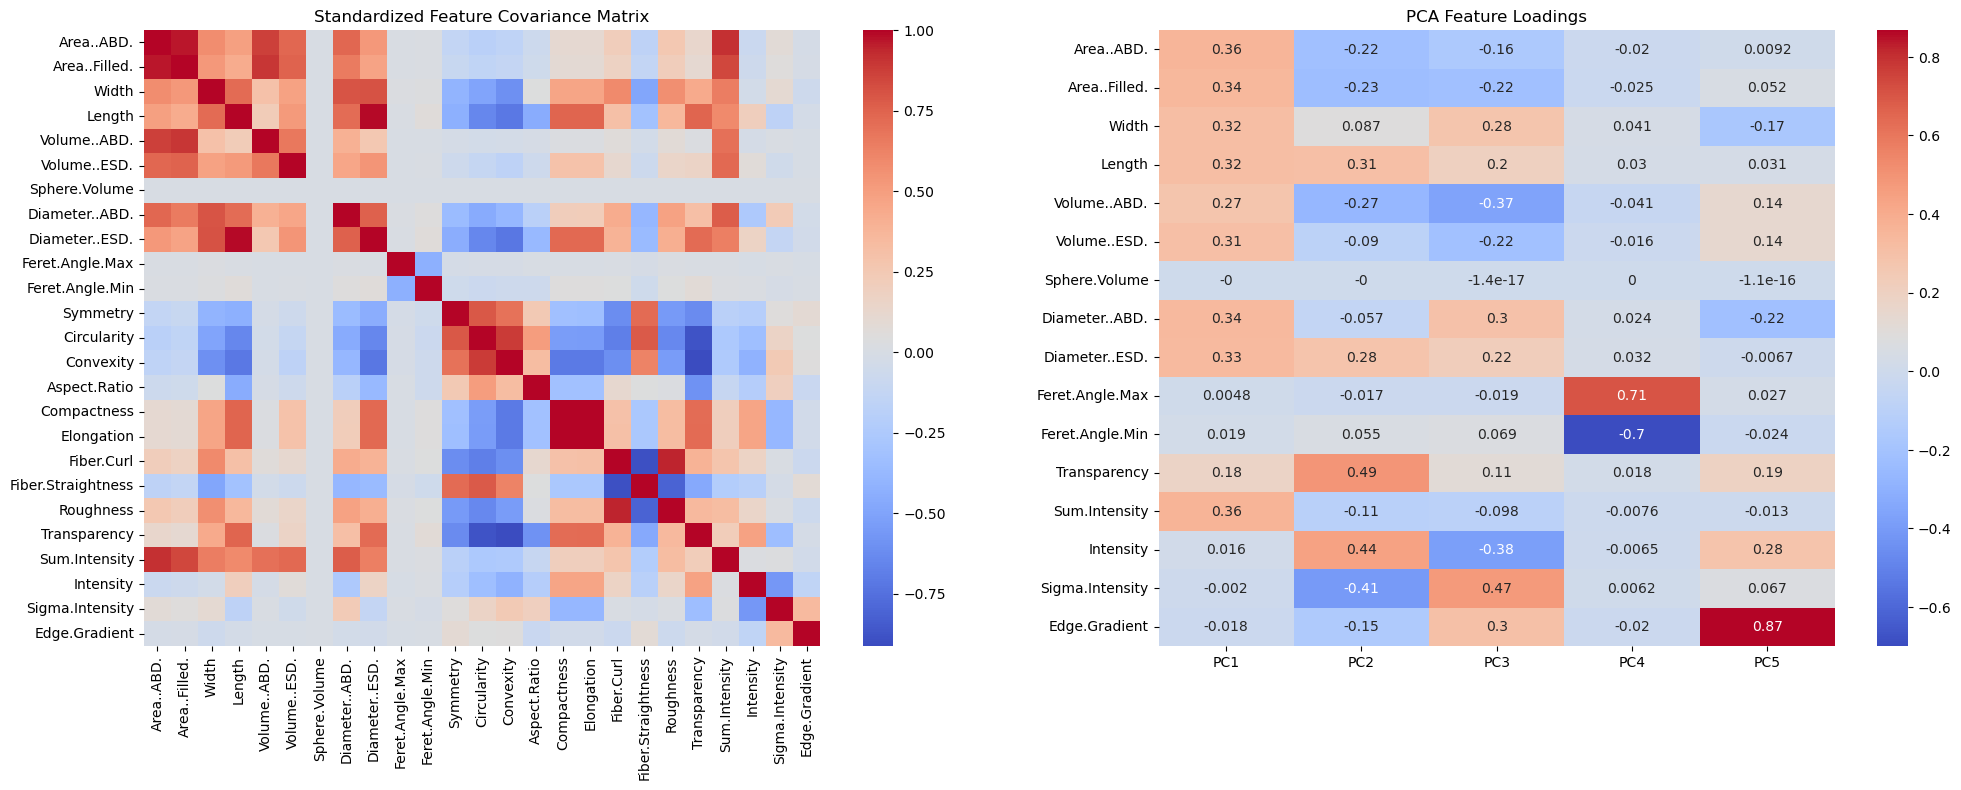

In [3]:
selected_columns = dimension_and_size_cols + structural_and_shape_cols + optical_cols

cov_matrix = merged_df[selected_columns].cov()

# standardize the data
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(merged_df[selected_columns]), columns=merged_df[selected_columns].columns)

# covariance matrix of standardized data
cov_matrix_scaled = df_scaled.cov()

# PCA
pca_columns = dimension_and_size_cols + optical_cols
pca_df = merged_df[pca_columns]
pca_df_scaled = scaler.fit_transform(pca_df)

# 5 principal components
pca = PCA(n_components=5)
principal_components = pca.fit_transform(pca_df_scaled)

loadings = pca.components_.T

# matrix of feature loadings
loading_df = pd.DataFrame(loadings, index=pca_df.columns, columns=[f'PC{i+1}' for i in range(5)])

fig, axes = plt.subplots(1, 2, figsize=(24, 8))
sns.heatmap(cov_matrix_scaled, annot=False, cmap="coolwarm", ax=axes[0])
axes[0].set_title("Standardized Feature Covariance Matrix")
sns.heatmap(loading_df, annot=True, cmap="coolwarm", ax=axes[1])
axes[1].set_title("PCA Feature Loadings")
plt.show()

Next, I investigated the class imbalance. The dataset reveals that 51.25% of the data is labeled as "TooSmall". Since this label does not provide meaningful information and exhibits high variability, it does not contribute to the classes we are focusing on. Given that more than half of the dataset is labeled as "TooSmall," it could introduce significant noise into the model. Thus, I decided to remove these instances.

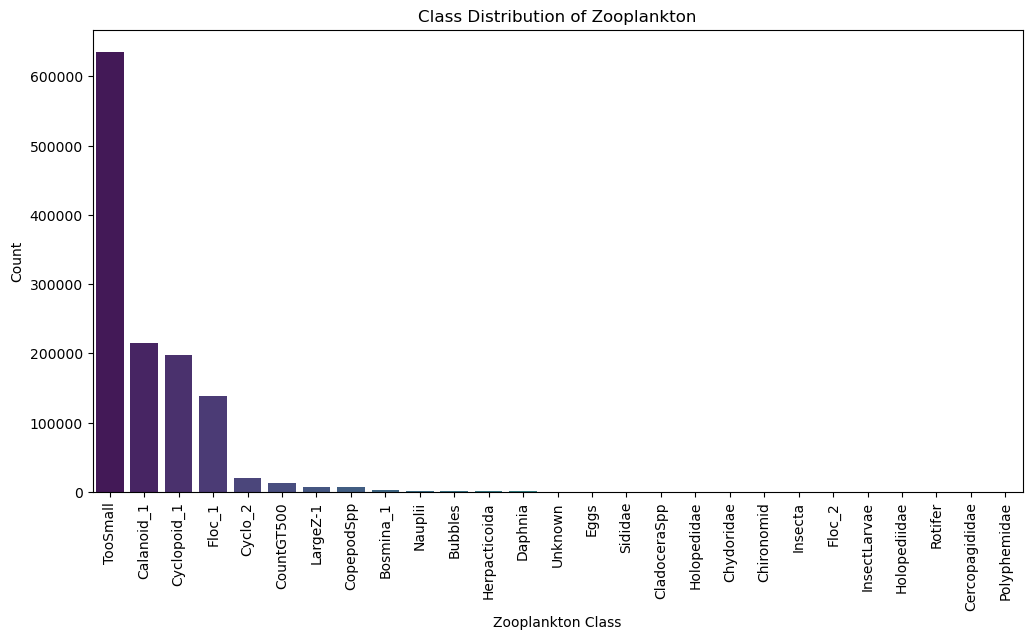

Percentage of 'TooSmall' class: 51.25%


In [4]:
# Get class counts
class_counts = merged_df["Class"].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, hue=class_counts.index, palette="viridis", legend=False)
plt.xticks(rotation=90)
plt.xlabel("Zooplankton Class")
plt.ylabel("Count")
plt.title("Class Distribution of Zooplankton")
plt.show()

# Calculate the percentage of 'TooSmall' class
too_small_percentage = (class_counts['TooSmall'] / class_counts.sum()) * 100
print(f"Percentage of 'TooSmall' class: {too_small_percentage:.2f}%")

# Exclude 'TooSmall' label
filtered_df = merged_df[merged_df['Class'] != 'TooSmall'].drop(columns=['Sphere.Volume'])
dimension_and_size_cols.remove('Sphere.Volume')


Finally, to identify unusual values and variations, I generated bar plots and box plots to detect severe outliers after removing "TooSmall" data. I found that Sphere.Volume contained only zero values, so I removed it. Additionally, the range of area and volume was extremely large, spanning from 30,000 to 600,000, with large values primarily associated with CountGT500, Bubble, and Floc_1.

However, I cannot simply remove all extreme values, as they are essential for detecting the plankton we aim to classify. At the same time, correctly identifying other plankton is important to prevent misclassification. Removing extreme values might lead to biased model training. Therefore, I decided not to exclude these values and will focus on handling them appropriately in further analysis.

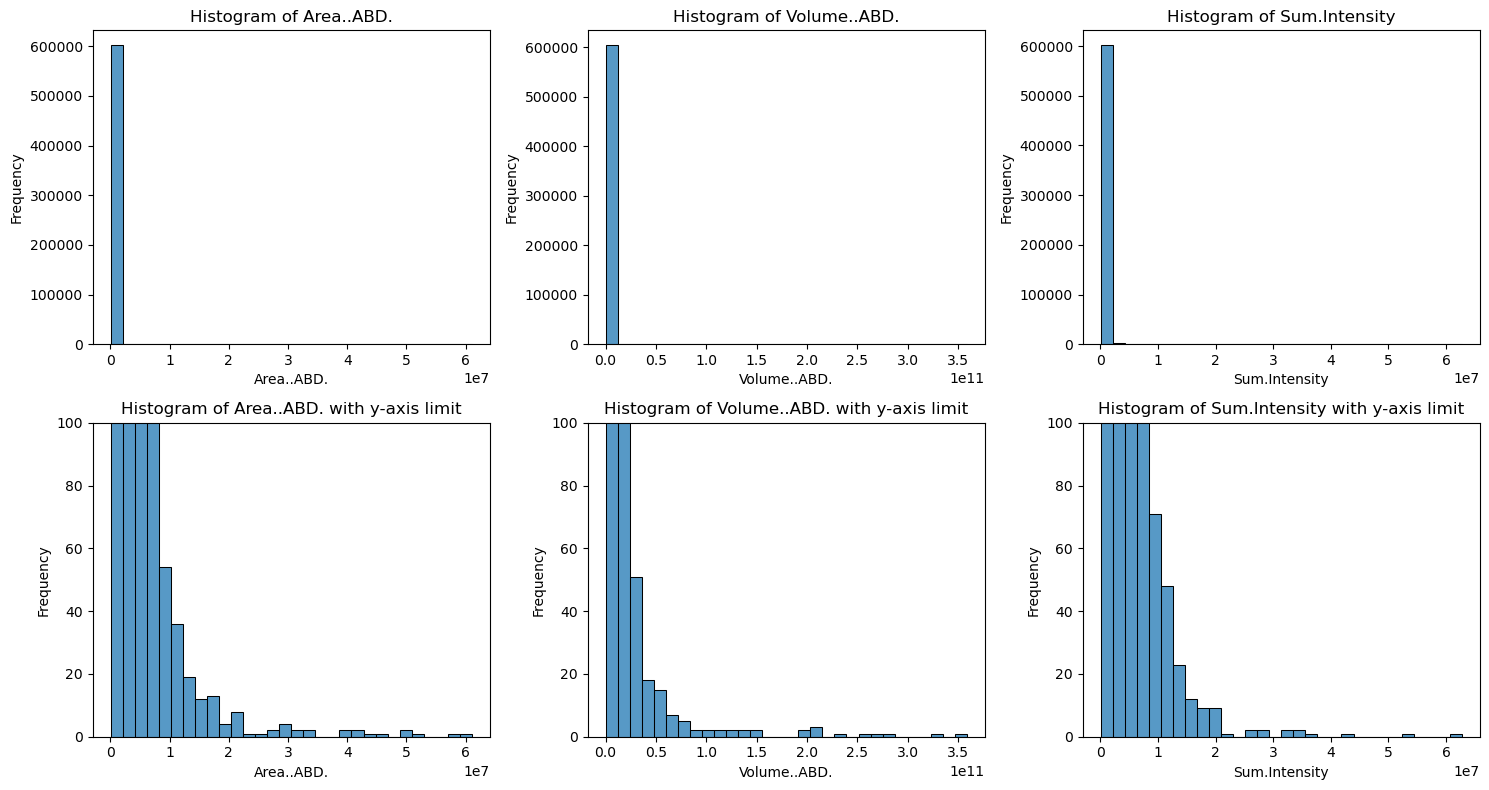

In [5]:
area_volume_cols = ['Area..ABD.', 'Volume..ABD.', 'Sum.Intensity']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(area_volume_cols):
    sns.histplot(filtered_df[col], bins=30, ax=axes[i])
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# histograms with y-limit
for i, col in enumerate(area_volume_cols):
    sns.histplot(filtered_df[col], bins=30, ax=axes[i + len(area_volume_cols)])
    axes[i + len(area_volume_cols)].set_title(f'Histogram of {col} with y-axis limit')
    axes[i + len(area_volume_cols)].set_xlabel(col)
    axes[i + len(area_volume_cols)].set_ylabel('Frequency')
    axes[i + len(area_volume_cols)].set_ylim(0, 100)

for j in range(2 * len(area_volume_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [6]:
top_10_largest_area_abd = filtered_df.sort_values(by='Area..ABD.', ascending=False).head(10)[['Area..ABD.', 'Class', 'Class.Particle.ID']]
top_10_largest_volume_abd = filtered_df.sort_values(by='Volume..ABD.', ascending=False).head(10)[['Volume..ABD.', 'Class', 'Class.Particle.ID']]
top_10_largest_sum_intensity = filtered_df.sort_values(by='Sum.Intensity', ascending=False).head(10)[['Sum.Intensity', 'Class', 'Class.Particle.ID']]

top_10_combined = pd.concat([top_10_largest_area_abd.reset_index(drop=True), top_10_largest_volume_abd.reset_index(drop=True), top_10_largest_sum_intensity.reset_index(drop=True)], axis=1)

print("Top 10 largest values by 'Area..ABD.' and 'Volume..ABD.' and 'Sum.Intensity'")
display(top_10_combined)

Top 10 largest values by 'Area..ABD.' and 'Volume..ABD.' and 'Sum.Intensity'


,Area..ABD.,Class,Class.Particle.ID,Volume..ABD.,Class,Class.Particle.ID,Sum.Intensity,Class,Class.Particle.ID
0,6.105333e+07,CountGT500,46,3.588623e+11,CountGT500,46,62763333.0,CountGT500,46
1,5.811282e+07,Bubbles,3,3.332512e+11,Bubbles,3,52608363.0,Bubbles,3
2,5.148212e+07,Bubbles,9,2.778743e+11,Bubbles,9,43412987.0,Bubbles,9
3,5.085988e+07,Bubbles,2,2.728518e+11,Bubbles,2,36174197.0,CountGT500,34
4,4.954963e+07,CountGT500,25,2.623762e+11,CountGT500,25,34429280.0,CountGT500,9
5,4.631464e+07,Floc_1,1323,2.371053e+11,Floc_1,1323,34428346.0,Floc_1,872
6,4.319049e+07,Floc_1,48,2.135237e+11,Floc_1,48,32894065.0,Floc_1,48
7,4.259959e+07,Floc_1,125,2.091567e+11,Floc_1,125,32251835.0,LargeZ-1,11
8,4.223865e+07,CountGT500,34,2.065042e+11,CountGT500,34,27743918.0,Floc_1,125
9,4.054100e+07,Floc_1,1326,1.941805e+11,Floc_1,1326,27315697.0,Bubbles,2
